<h1>Esteganografia SSB-4</h1>

<h3>Importação das Bibliotecas</h3>

In [18]:
import numpy as np
import pandas as pd
from skimage.transform import rescale
import skimage
import bitarray
import math
import cv2
import random
from scipy import fftpack
from skimage.io import imread, imshow, imsave

<h3>Declaração das Funções</h3>

In [19]:
def __messageToBits(message):
    tag = "{:<10}".format(str(len(message)*8))
    message = tag+message
    code = bitarray.bitarray()
    code.frombytes(message.encode('utf-8'))
    code = "".join(['1' if x == True else '0' for x in code.tolist()])
    return code

In [20]:
def __hideMessage(img, message):
    vetNormalize = [232, 233, 234, 235, 236, 237, 238, 239, 248, 249, 250, 251, 252, 253, 254, 255]

    shape = img.shape
    img = img.flatten()
    code = list(message)
    code_len = len(code)
    for i,x in enumerate(img):
        if i <code_len:
            valorPixel = x
            tempDiff = 256
            zListTemp = list('{0:08b}'.format(x))
            zbits = zListTemp[:4]+[code[i]]+zListTemp[5:]
            img[i] = int("".join(zbits), 2)

            for j in vetNormalize:
                if abs((img[i] & j)-img[i]) < tempDiff:
                    valorPixel = (img[i] & j)
                    tempDiff = abs((img[i] & j)-img[i])

            img[i] = valorPixel
        else:
            return img.reshape(shape)
    return img.reshape(shape)

In [21]:
def __toGrayscale(imageA):
    r = imageA[:,:,0]
    g = imageA[:,:,1]
    b = imageA[:,:,2]

    shapeImage = imageA.shape;
    retImage = np.zeros((shapeImage[0], shapeImage[1]))

    for i in range(shapeImage[0]):
        for j in range(shapeImage[1]):
            retImage[i][j] = int(0.2126*r[i][j] + 0.7152*g[i][j] + 0.0722*b[i][j])

    return retImage.astype("uint8")

In [22]:
def encode(cover_image, secret_message):
    cover_image = __toGrayscale(cover_image)

    image_height  = cover_image.shape[0]
    image_width   = cover_image.shape[1]

    image_size_bytes = image_height * image_width
    image_size_bits  = image_size_bytes * 8
    image_size_kbytes = image_size_bytes / 1024

    hide_size_bits  = image_size_bytes
    hide_size_kbytes = (hide_size_bits / 8) / 1024

    message_size_kbytes = len(secret_message)/8000

    if message_size_kbytes > hide_size_kbytes:
        raise Exception('Mensagem muito grande!')

    secret_message_bits = __messageToBits(secret_message)

    image_with_message = __hideMessage(cover_image, secret_message_bits)

    return image_with_message

In [23]:
def decode(cover_image):
    bit_message = ""
    bit_count = 0
    bit_length = 200
    for i,x in enumerate(cover_image):
        for j,y in enumerate(x):
            zbits = '{0:08b}'.format(y)
            bit_message += zbits[4]
            bit_count += 1
            if bit_count == 80:
                try:
                    decoded_tag = bitarray.bitarray(bit_message).tobytes().decode('utf-8')
                    bit_length = int(decoded_tag)+80
                    bit_message = ""
                except:
                    print("Ocorreu um erro ao obter a mensagem!")
                    return
            elif bit_count >= bit_length:
                return bitarray.bitarray(bit_message).tobytes().decode('utf-8')

<h3>Leitura da Imagem de Capa</h3>

In [24]:
imgCapa = imread('../imagem.jpg')

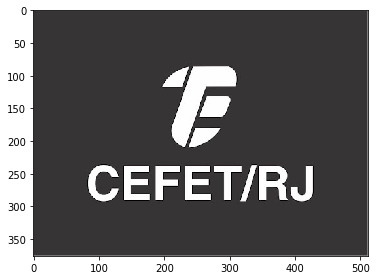

In [25]:
imshow(imgCapa)

<h3>Armazena a string <code><em>Hello World!</em></code> na imagem de capa</h3>
<p>Utilizando a técnica SSB-4</p>

In [26]:
imgEstg = encode(imgCapa, 'Hello World!')

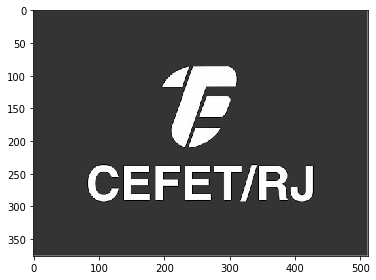

In [27]:
imshow(imgEstg)

<h3>Lê a string contida na imagem de capa</h3>

In [28]:
decode(imgEstg)

'Hello World!'

<h3>Salva a imagem de capa no formato bitmap, lê o arquivo salvo e decodifica novamente a mensagem secreta</h3>

In [29]:
imsave('ssb4.bmp', imgEstg)

In [30]:
imgSaved = imread('ssb4.bmp')

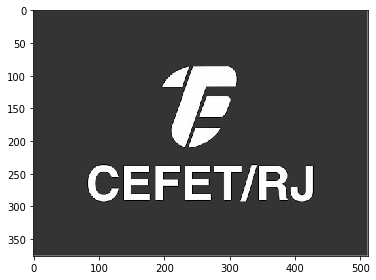

In [31]:
imshow(imgSaved)

In [32]:
decode(imgSaved)

'Hello World!'